#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from models import CNN

BATCH_SIZE = 128
DOWNLOAD = False  # True if no dataset on local disk
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [5]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/LBFGS_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [6]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [9]:
import time 
import torch.optim as optim

def modeling(n_step=2, n_epochs=15):
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for epoch in range(n_epochs):
#         print(epoch)
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
#             print(f'epoch {epoch:3d}, batch {i:4d}')
            
            optimizer = optim.LBFGS(model.parameters(), 
                                    lr = 0.9,
                                    
                                    max_iter=n_step, 
                                    history_size=20,)
                            
            images, labels = images.to(device), labels.to(device)
            # Forward
            def closure():
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    if loss.requires_grad:
                        loss.backward()
                    return loss
            loss = optimizer.step(closure)
            running_loss += loss.item()

            # Training accuracy
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()
            
#             print(f'Train acc:{_train_acc:.4f}, Err: {_train_err:.4f}')

        run_time = time.time() - _start
        print(f'Runtime: {run_time}')
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

In [10]:
from plot import metrics_plot
n_epochs = 100
n_step = 10
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs,
                                                                                  )
save_path = 'metrics'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

Runtime: 78.33503651618958
E [1/100]. train_loss_acc: 4.7059, 46.33%, test_acc: 10.87%, run_time: 78.33503651618958
Runtime: 75.45145893096924
E [2/100]. train_loss_acc: 1632.8800, 12.77%, test_acc: 10.16%, run_time: 75.45145893096924
Runtime: 77.55059671401978
E [3/100]. train_loss_acc: 2087.8555, 10.99%, test_acc: 7.65%, run_time: 77.55059671401978


KeyboardInterrupt: 

E [1/100]. train_loss_acc: 5.3181, 13.59%, test_acc: 15.53%, run_time: 26.45042848587036
E [11/100]. train_loss_acc: 73052.9451, 10.96%, test_acc: 10.00%, run_time: 25.884782552719116
E [21/100]. train_loss_acc: 22135247900634.4648, 10.11%, test_acc: 10.00%, run_time: 25.824265956878662
E [31/100]. train_loss_acc: 42368396065183227904.0000, 10.07%, test_acc: 10.00%, run_time: 25.890904426574707
E [41/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.966164350509644
E [51/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.939963340759277
E [61/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.929097175598145
E [71/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.893483877182007
E [81/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.908475160598755
E [91/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 25.843597412109375


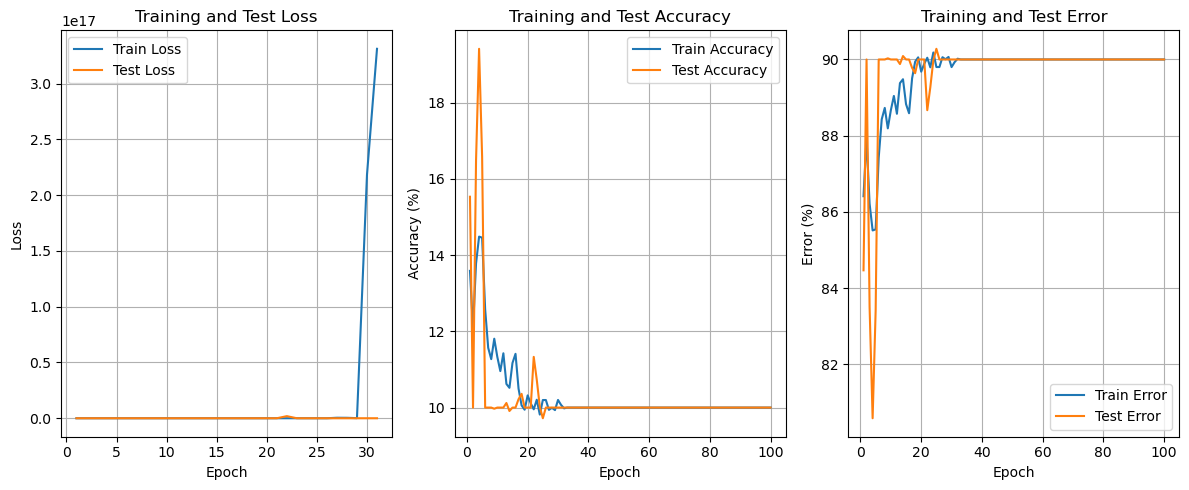

In [5]:
from plot import metrics_plot
n_epochs = 100
n_step = 2
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs,
                                                                                  )
save_path = 'metrics'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [ ]:
from plot import metrics_plot
n_epochs = 100
n_step = 3
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs,
                                                                                  )
save_path = 'metrics'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [ ]:
from plot import metrics_plot
n_epochs = 100
n_step = 5
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs,
                                                                                  )
save_path = 'metrics'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

E [1/100]. train_loss_acc: 1.6352, 61.07%, test_acc: 54.61%, run_time: 144.38458967208862
E [11/100]. train_loss_acc: 0.7962, 97.07%, test_acc: 81.11%, run_time: 143.51246976852417
E [21/100]. train_loss_acc: 8705.6518, 10.56%, test_acc: 10.31%, run_time: 142.76666927337646
E [31/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.91040134429932
E [41/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.91956067085266
E [51/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.91356348991394
E [61/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.83705759048462
E [71/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 144.2133641242981
E [81/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.7808072566986
E [91/100]. train_loss_acc: nan, 10.00%, test_acc: 10.00%, run_time: 142.85268807411194


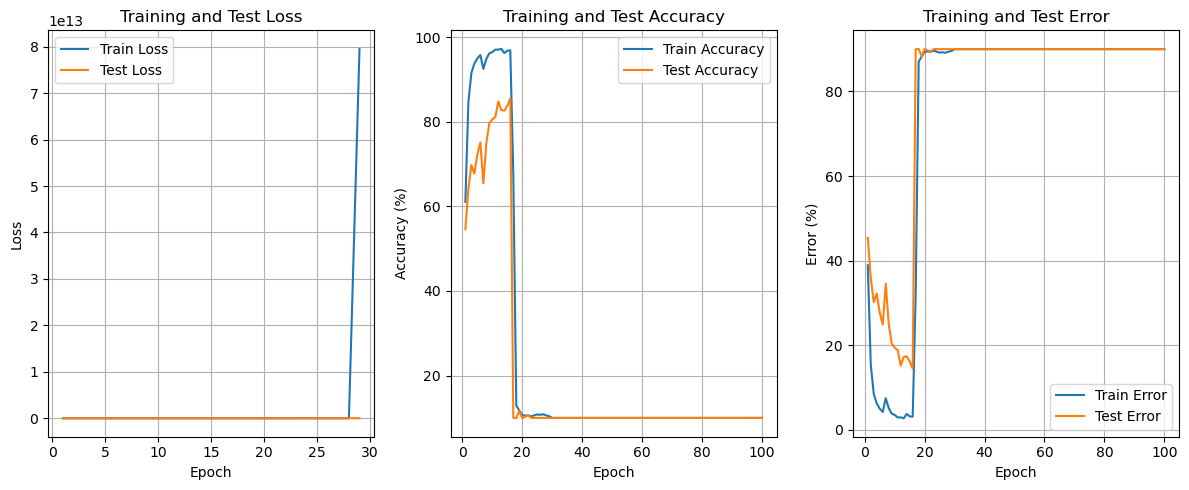

In [5]:
from plot import metrics_plot
n_epochs = 100
n_step = 10
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs,
                                                                                  )
save_path = 'metrics'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [1]:
pwd

'/home/tung5534/cnn_cifar'